Before running, follow the installation instructions in the `AdversarialInfluenceWorkbench/examples/microcredit_mixture/README.md` file.

In [1]:
import paragami
import vittles
import autograd
from autograd import numpy as np
from autograd import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import time
import scipy as osp

In [2]:
import microcredit_mixture_rgiordandev
from microcredit_mixture_rgiordandev import microcredit_vb_lib as mm_lib

In [3]:
from microcredit_mixture_rgiordandev import \
    get_log_prob, get_param_pattern, get_log_prob_with_jacobian

In [4]:
np.random.seed(42)

## Load the data and previous analysis

In [5]:
use_smuber = False
num_draws = 20

In [6]:
raw_data = pd.read_csv('../R/data/microcredit_project_data_cleaned.csv') 
data = dict()

data['site'] = raw_data["site"].to_numpy().astype('int')
data['profit'] = raw_data["profit"].to_numpy()
data['treatment'] = raw_data["treatment"].to_numpy().astype('int')
data['cat'] = raw_data["cat"].to_numpy().astype('int')

# If use_smuber is False or unset, then use the log normal loss.
data['use_smuber'] = use_smuber

In [7]:
out_filename = 'output/microcredit_project_advi_{}draws_smuber{}.npz'.format(num_draws, use_smuber)

advi_dict = np.load(out_filename)

advi_param_pattern = paragami.get_pattern_from_json(str(advi_dict['advi_param_pattern_json']))
param_pattern = paragami.get_pattern_from_json(str(advi_dict['param_pattern_json']))
advi_param_pattern = paragami.get_pattern_from_json(str(advi_dict['advi_param_pattern_json']))
param_pattern = paragami.get_pattern_from_json(str(advi_dict['param_pattern_json']))
hess0 = advi_dict['hess0']
advi_params_free = advi_dict['advi_params_free']
advi_params = advi_param_pattern.fold(advi_params_free, free=True)
#mean_params = param_pattern.fold(advi_dict['params_free'], free=True)
base_draws = advi_dict['base_draws']
prior_pattern = paragami.get_pattern_from_json(str(advi_dict['prior_param_pattern_json']))
prior_params = prior_pattern.fold(advi_dict['prior_params_flat'], free=False)

In [8]:
sens_filename = 'output/microcredit_project_weight_sensitivity_{}draws_smuber{}.npz'.format(
    num_draws, use_smuber)
sens_dict = np.load(sens_filename)
lr_cov = sens_dict['lr_cov']
advi_mean_free_jacobian = sens_dict['advi_mean_free_jacobian']

In [9]:
mm_lib.get_advi_loss(advi_params, base_draws, data, prior_params, param_pattern)

35733.613593279995

In [10]:
base_draws.shape

(124, 20)

In [11]:
# Estimate the score covariance.
use_base_draws_for_cov = True
if use_base_draws_for_cov:
    score_cov_draws = base_draws
else:
    score_cov_draws = mm_lib.get_base_draws(100, param_pattern)

# Recall that each column of the base draws is a MVN draw.
objective_grads = []
for d in range(score_cov_draws.shape[1]):
    single_draw = score_cov_draws[:, d]
    single_draw = single_draw[:, None]
    objective = mm_lib.get_advi_objective(
        single_draw, data, prior_params, advi_param_pattern, param_pattern)
    objective_grads.append(objective.grad(advi_params_free))

objective_grads = np.array(objective_grads)

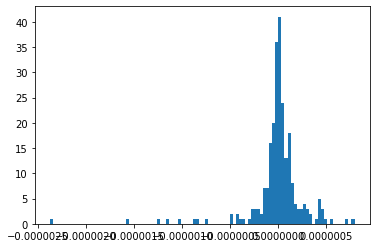

In [12]:
# The mean score is not necessarily close to zero with draws other than base_draws,
# though you would hope it would be.
plt.hist(np.mean(objective_grads, axis=0), 100);

In [13]:
# The means should be close to zero because of optimization, but let's do it carefully.
score_centered = objective_grads - np.mean(objective_grads, axis=0, keepdims=True)
score_cov = score_centered.T @ score_centered / score_cov_draws.shape[1]

# This is the estimate of the frequentist variance of the optimal ADVI parameters
# under samples of base_draws.
advi_param_cov = np.linalg.solve(hess0, np.linalg.solve(hess0, score_cov).T) / num_draws

# This is the delta method estimate of the frequentist variance of the VB mean parameters
# under samples of base_draws.
advi_mean_freq_cov = advi_mean_free_jacobian @ advi_param_cov @ advi_mean_free_jacobian.T

In [14]:
# Compare the frequentist standard errors to the LR posterior standard deviation. 
advi_mean_freq_sd = np.sqrt(np.diag(advi_mean_freq_cov))
rel_error_flat = advi_mean_freq_sd / np.sqrt(np.diag(lr_cov))
rel_error = param_pattern.fold(rel_error_flat, free=False)

In [17]:
save_dict = {}
save_dict['out_filename'] = out_filename
save_dict['sens_filename'] = sens_filename
save_dict['base_draws'] = base_draws
save_dict['use_smuber'] = use_smuber

save_dict['use_base_draws_for_cov'] = use_base_draws_for_cov
save_dict['objective_grads'] = objective_grads
save_dict['advi_param_cov'] = advi_param_cov
save_dict['advi_param_cov'] = advi_param_cov
save_dict['rel_error_flat'] = rel_error_flat
save_dict['param_pattern_json'] = param_pattern.to_json()

In [18]:
freq_filename = 'output/microcredit_project_advi_frequentist_num_draw_check_{}draws_smuber{}.npz'.format(
    base_draws.shape[1], data['use_smuber'])
print('Saving to {}'.format(freq_filename))

np.savez_compressed(**save_dict, file=freq_filename)

Saving to output/microcredit_project_advi_frequentist_num_draw_check_20draws_smuberFalse.npz
